### Import Dependencies

In [23]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps 
from tqdm import tqdm
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib as mpl
import matplotlib.pyplot as plt
from svcviz.viz_gwr import viz_gwr, viz_gw, compare_conf, compare_two_surf
import warnings
warnings.filterwarnings('ignore')

#### Preprocessing

- Load the datasets into pandas and geopandas dataframes

In [2]:
df = pd.read_csv("countypres_2000-2020.csv")
df2 = pd.read_csv("voting_2020.csv")[["county_id","pct_black", "total_pop", 
                                                "pct_hisp", "median_income",
                                               "pct_65_over", "pct_age_18_29", 
                                                "pct_fb", "sex_ratio", "ln_pop_den",
                                               "pct_bach", "pct_uninsured", "median_income"]]

dfgp  = pd.read_csv("ggp-us-dfii.csv").drop('delete', axis=1)

df3 = dfgp[['id', 'se0', 'b0', 'Intercept','sepct_black',
       'bpct_black', 'sepct_hisp', 'bpct_hisp', 'sepct_65_over', 'bpct_65_over', 'sepct_age_18_29',
       'bpct_age_18_29', 'sepct_fb', 'bpct_fb', 'sepct_uninsured',
       'bpct_uninsured', 'sepct_bach', 'bpct_bach', 'seln_pop_den',
       'bln_pop_den']]

- Get 2020 U.S election data + democrat party and exclude D.C, Hawaii, and Alaska
- create a geometry attribute from GeoJSON file 
- Set the CRS
- visualize the counties in the U.S

In [3]:
df = df[(df.year==2020) & (df.party=='DEMOCRAT') & (df.state!='DISTRICT OF COLUMBIA')] 

In [4]:
df = df[["state", "county_name", "county_fips","party", "totalvotes", "mode"]]

In [5]:
df3.head(2)

id       se0        b0  Intercept  sepct_black  bpct_black  sepct_hisp  \
0  1001  0.109232 -0.161032          1     0.036349    0.046597    0.283512   
1  1003  0.136123 -0.102484          1     0.053384    0.012584    0.344177   

   bpct_hisp  sepct_65_over  bpct_65_over  sepct_age_18_29  bpct_age_18_29  \
0  -0.126066       0.070951      0.043623         0.052382       -0.056577   
1  -0.064931       0.088085      0.087716         0.080351       -0.025321   

   sepct_fb   bpct_fb  sepct_uninsured  bpct_uninsured  sepct_bach  bpct_bach  \
0  0.155654  0.188183         0.026215        0.031122    0.064936   0.099549   
1  0.201540  0.212545         0.030258        0.040352    0.083381   0.062685   

   seln_pop_den  bln_pop_den  
0      0.097896     0.278338  
1      0.113054     0.310424

In [6]:
newdf = df.merge(df2, left_on='county_fips', right_on='county_id', how='right')

In [7]:
newdf = newdf[(newdf['mode']=='TOTAL') | (newdf['mode']=='ELECTION DAY')]

In [8]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty].copy()

counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [9]:
data = counties_non_empty.merge(newdf, left_on='id', right_on='county_fips')

In [10]:
data = data[data.state!='HAWAII']

In [11]:
data.set_crs(epsg=4269, allow_override=True, inplace=True)
data = data.to_crs(epsg=4269)

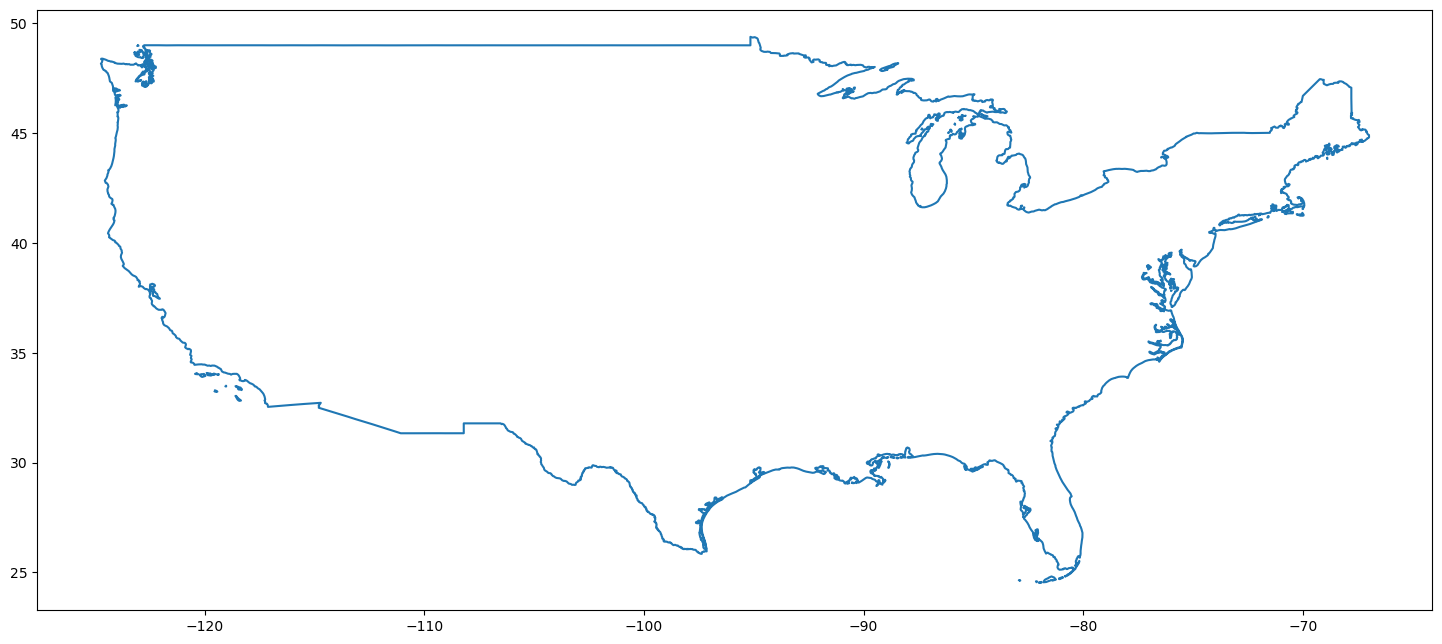

In [12]:
data['geometry'] = data.buffer(0)
gpd.GeoSeries(data.unary_union.boundary).plot(figsize=(18,12))
plt.show()


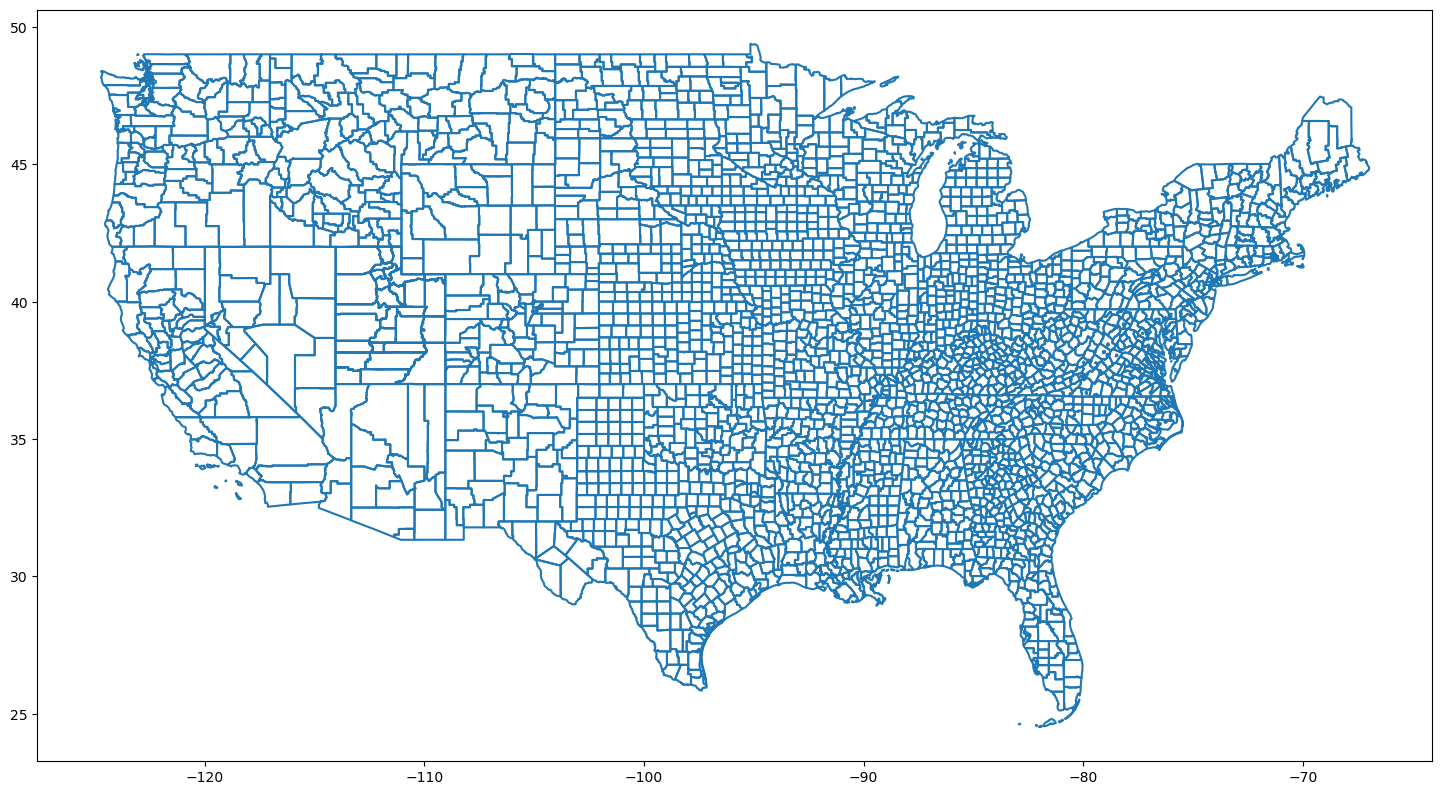

In [13]:
data.boundary.plot(figsize=(18,12));


In [14]:
g_y = data['totalvotes'].values.reshape((-1,1))
g_X = data[[
    'pct_black','pct_hisp','pct_65_over','pct_age_18_29',
            'pct_fb', 'pct_uninsured', 'pct_bach', 'ln_pop_den'
            ]].values

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = data["lon"]
v = data["lat"]

g_coords = list(zip(u,v))

In [15]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
print('Bandwidth is:', gwr_bw)
print('=======================')
print('Resid SS is:', gwr_results.resid_ss)
print('=======================')
print('ENP is:', gwr_results.ENP)
print('=======================')
print('AICc is:', gwr_results.aicc)

# gwr_results.summary()

Bandwidth is: 143.0
Resid SS is: 904.7533722425316
ENP is: 451.3961065192949
AICc is: 6058.0439707854275


In [16]:
gwr_results.critical_tval()

3.2945086947640676

# Demo

### Utility 1 

- This Utillity of the "svc-viz" tool takes as input a GWR model object and generates coefficient surfaces incorporating the visualization best practices discussed in the special issue paper to ensure reproducible research

- By default the tool visualizes all the coefficients. The User then only needs to specify which coefficient surfaces they want to visualize by passing them as argument and they could turn the t-values on/off (by default the tvalues are at 0.05 significance level but could be adjusted)

- A pretty cool thing is it could also be used for other svc models that are not GWR

- Below is an example code with a gwr model object

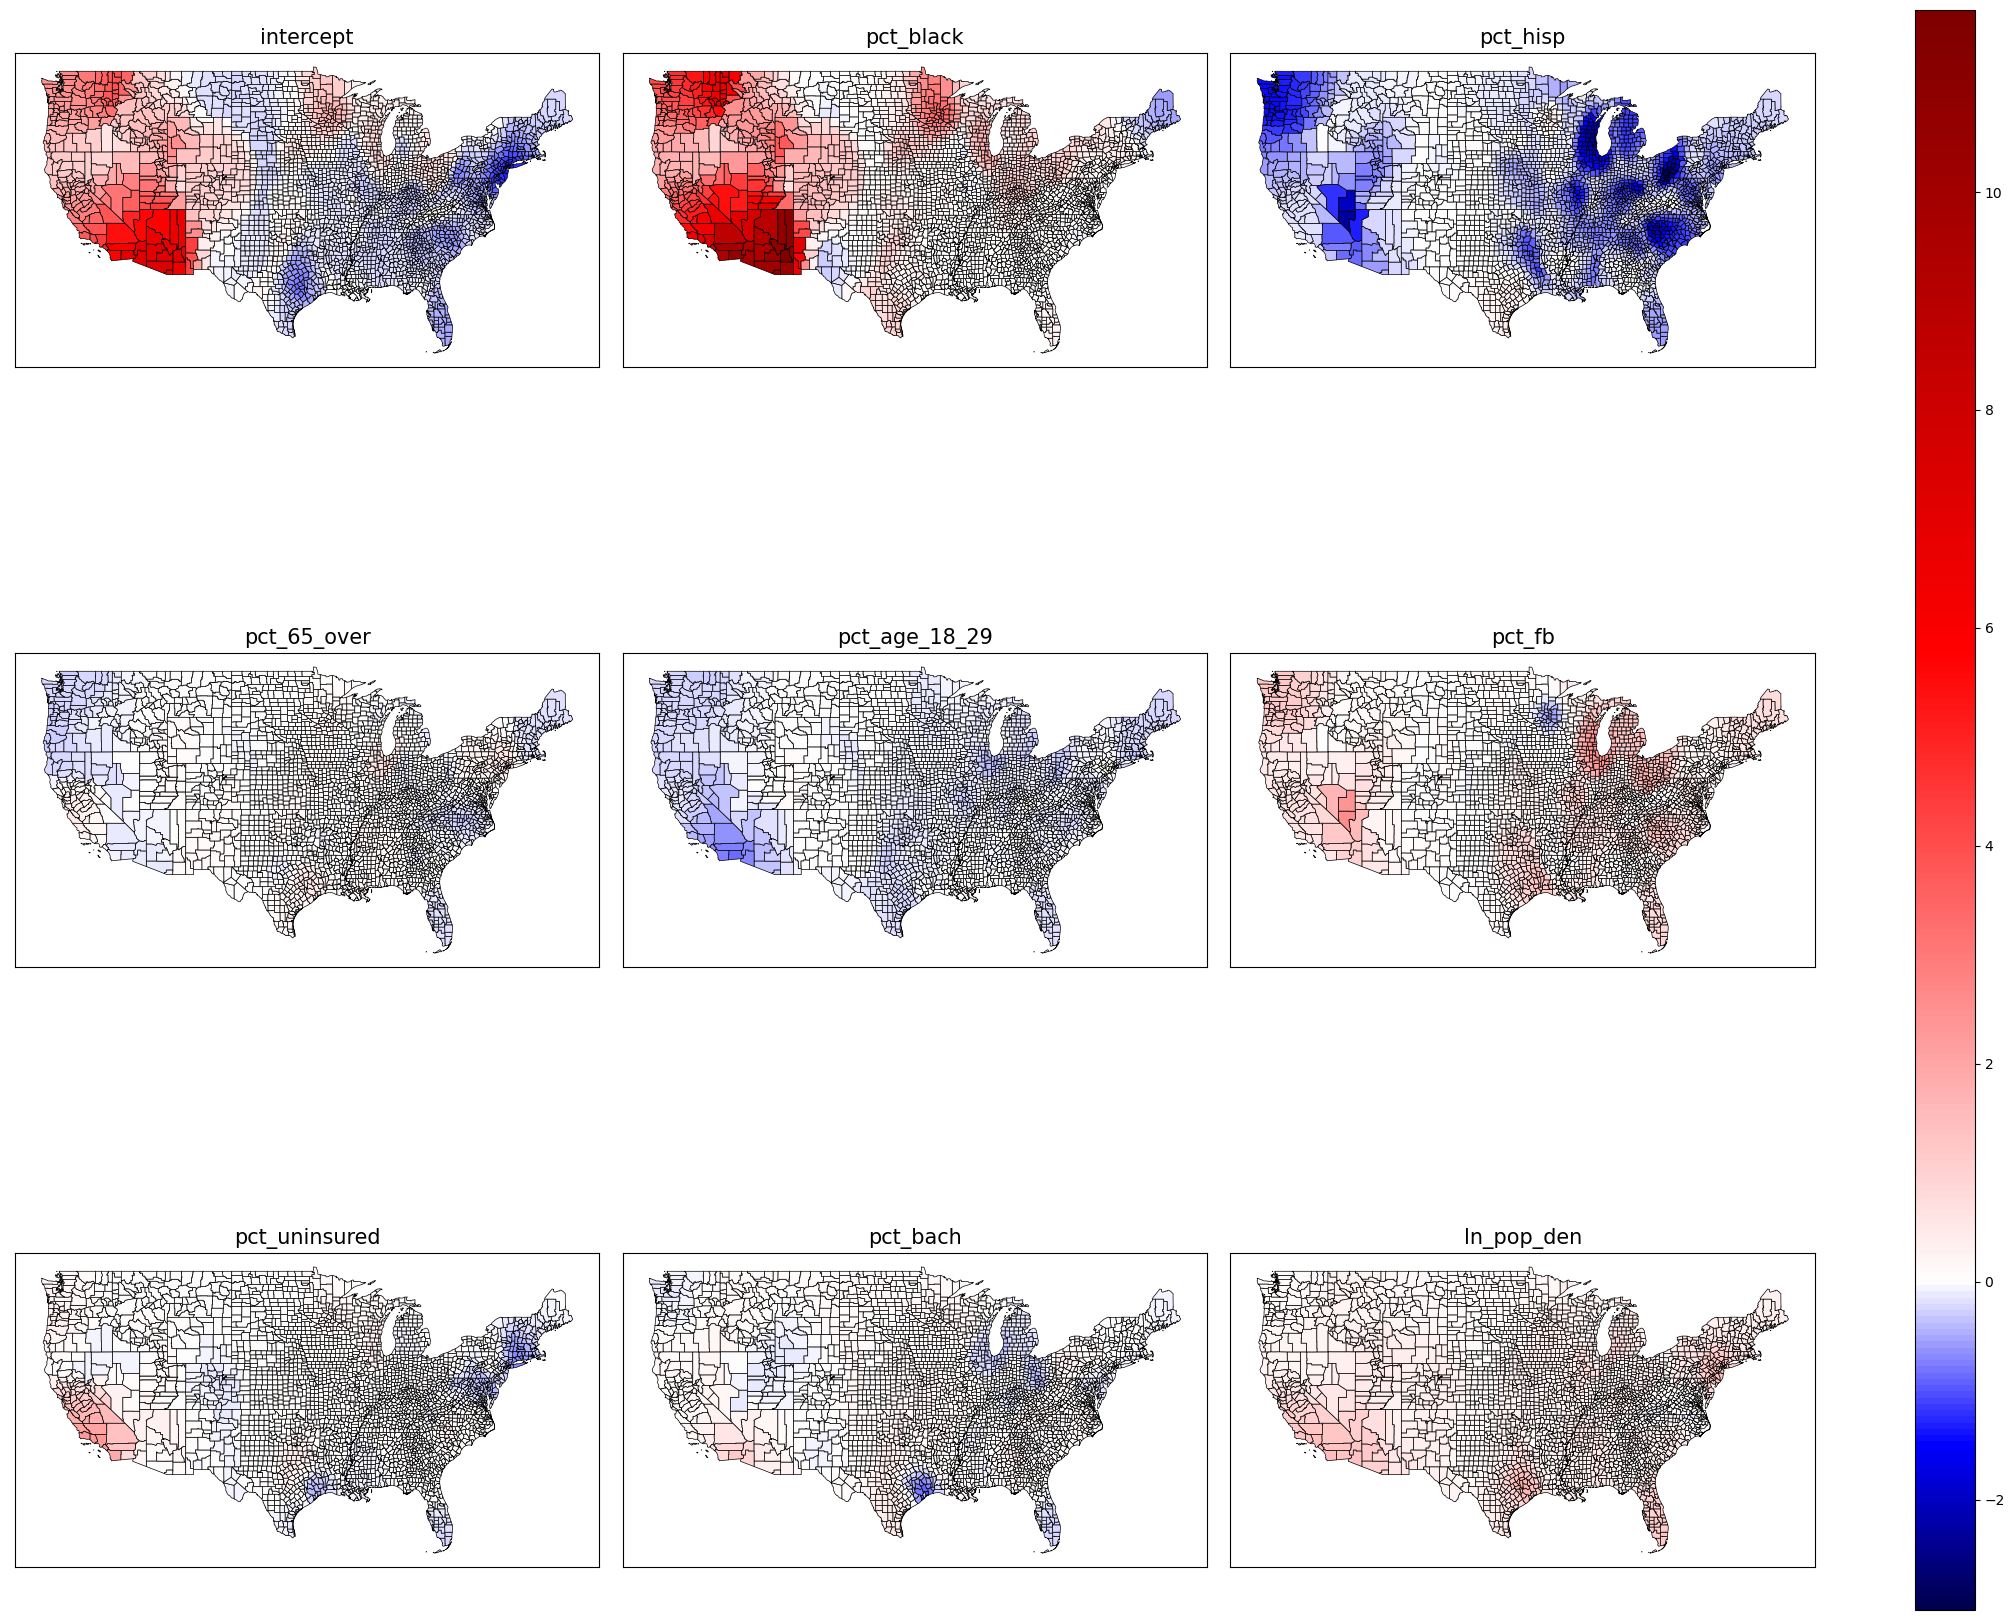

In [17]:
col_names = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
    'pct_uninsured', 'pct_bach', 'ln_pop_den']

viz_gwr(
        col_names, 
        data['geometry'], 
        gwr_results, 
        use_tvalues=False, 
        alpha=0.5, 
#         coef_surfaces=['intercept']
)

#### User specifies what surfaces they want to visualize, following best practices we recommend in the paper

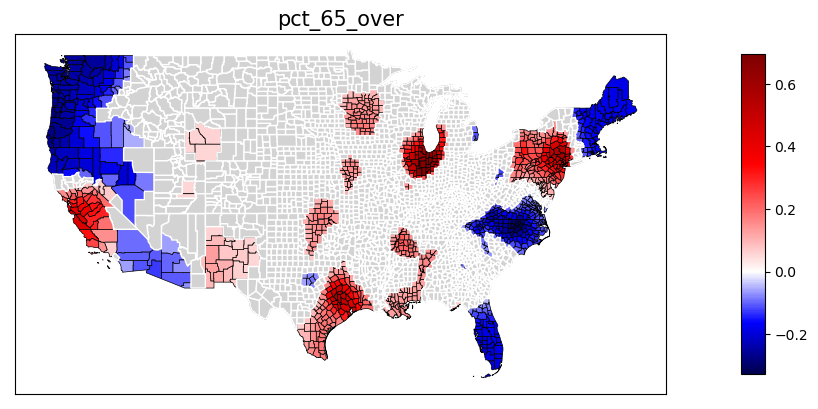

In [18]:
viz_gwr(
        col_names, 
        data['geometry'], 
        gwr_results, 
        use_tvalues=True, 
        alpha=0.5, 
        coef_surfaces=['pct_65_over']
)

- In addition to the Utility 1 for GWR models, the tool also has the functionality for creating a 3-panel visualization which is essential a multiview visualization that displays different yet relating information about a single variable, including bandwidth and its confidence intervals, a carterpillar plot visualizing the confidence intervals, and finally the coefficient surface.

- It takes as input the bandwidth object and the gwr result objects. 

<br/>

<br/>

## Utility 2


- The svc-viz is not only restricted to GWR models but can also be extended to any other svc model or geographically weighted statistic. 

- It takes in as argument the original dataframe, the dataframe of the model estimates and their standard errors, and the level of statistical significance for the tvalues. By default, it is set to 0.05

- Using these arguments it generates visualization of all the model coefficients like in utility 1 and following the best visualization practices disscussed in the paper for R&R

- Below is an example code for the visualization of a GAM model calibrated with gaussian process splines. The user just needs to pass in to the function the required dataframes

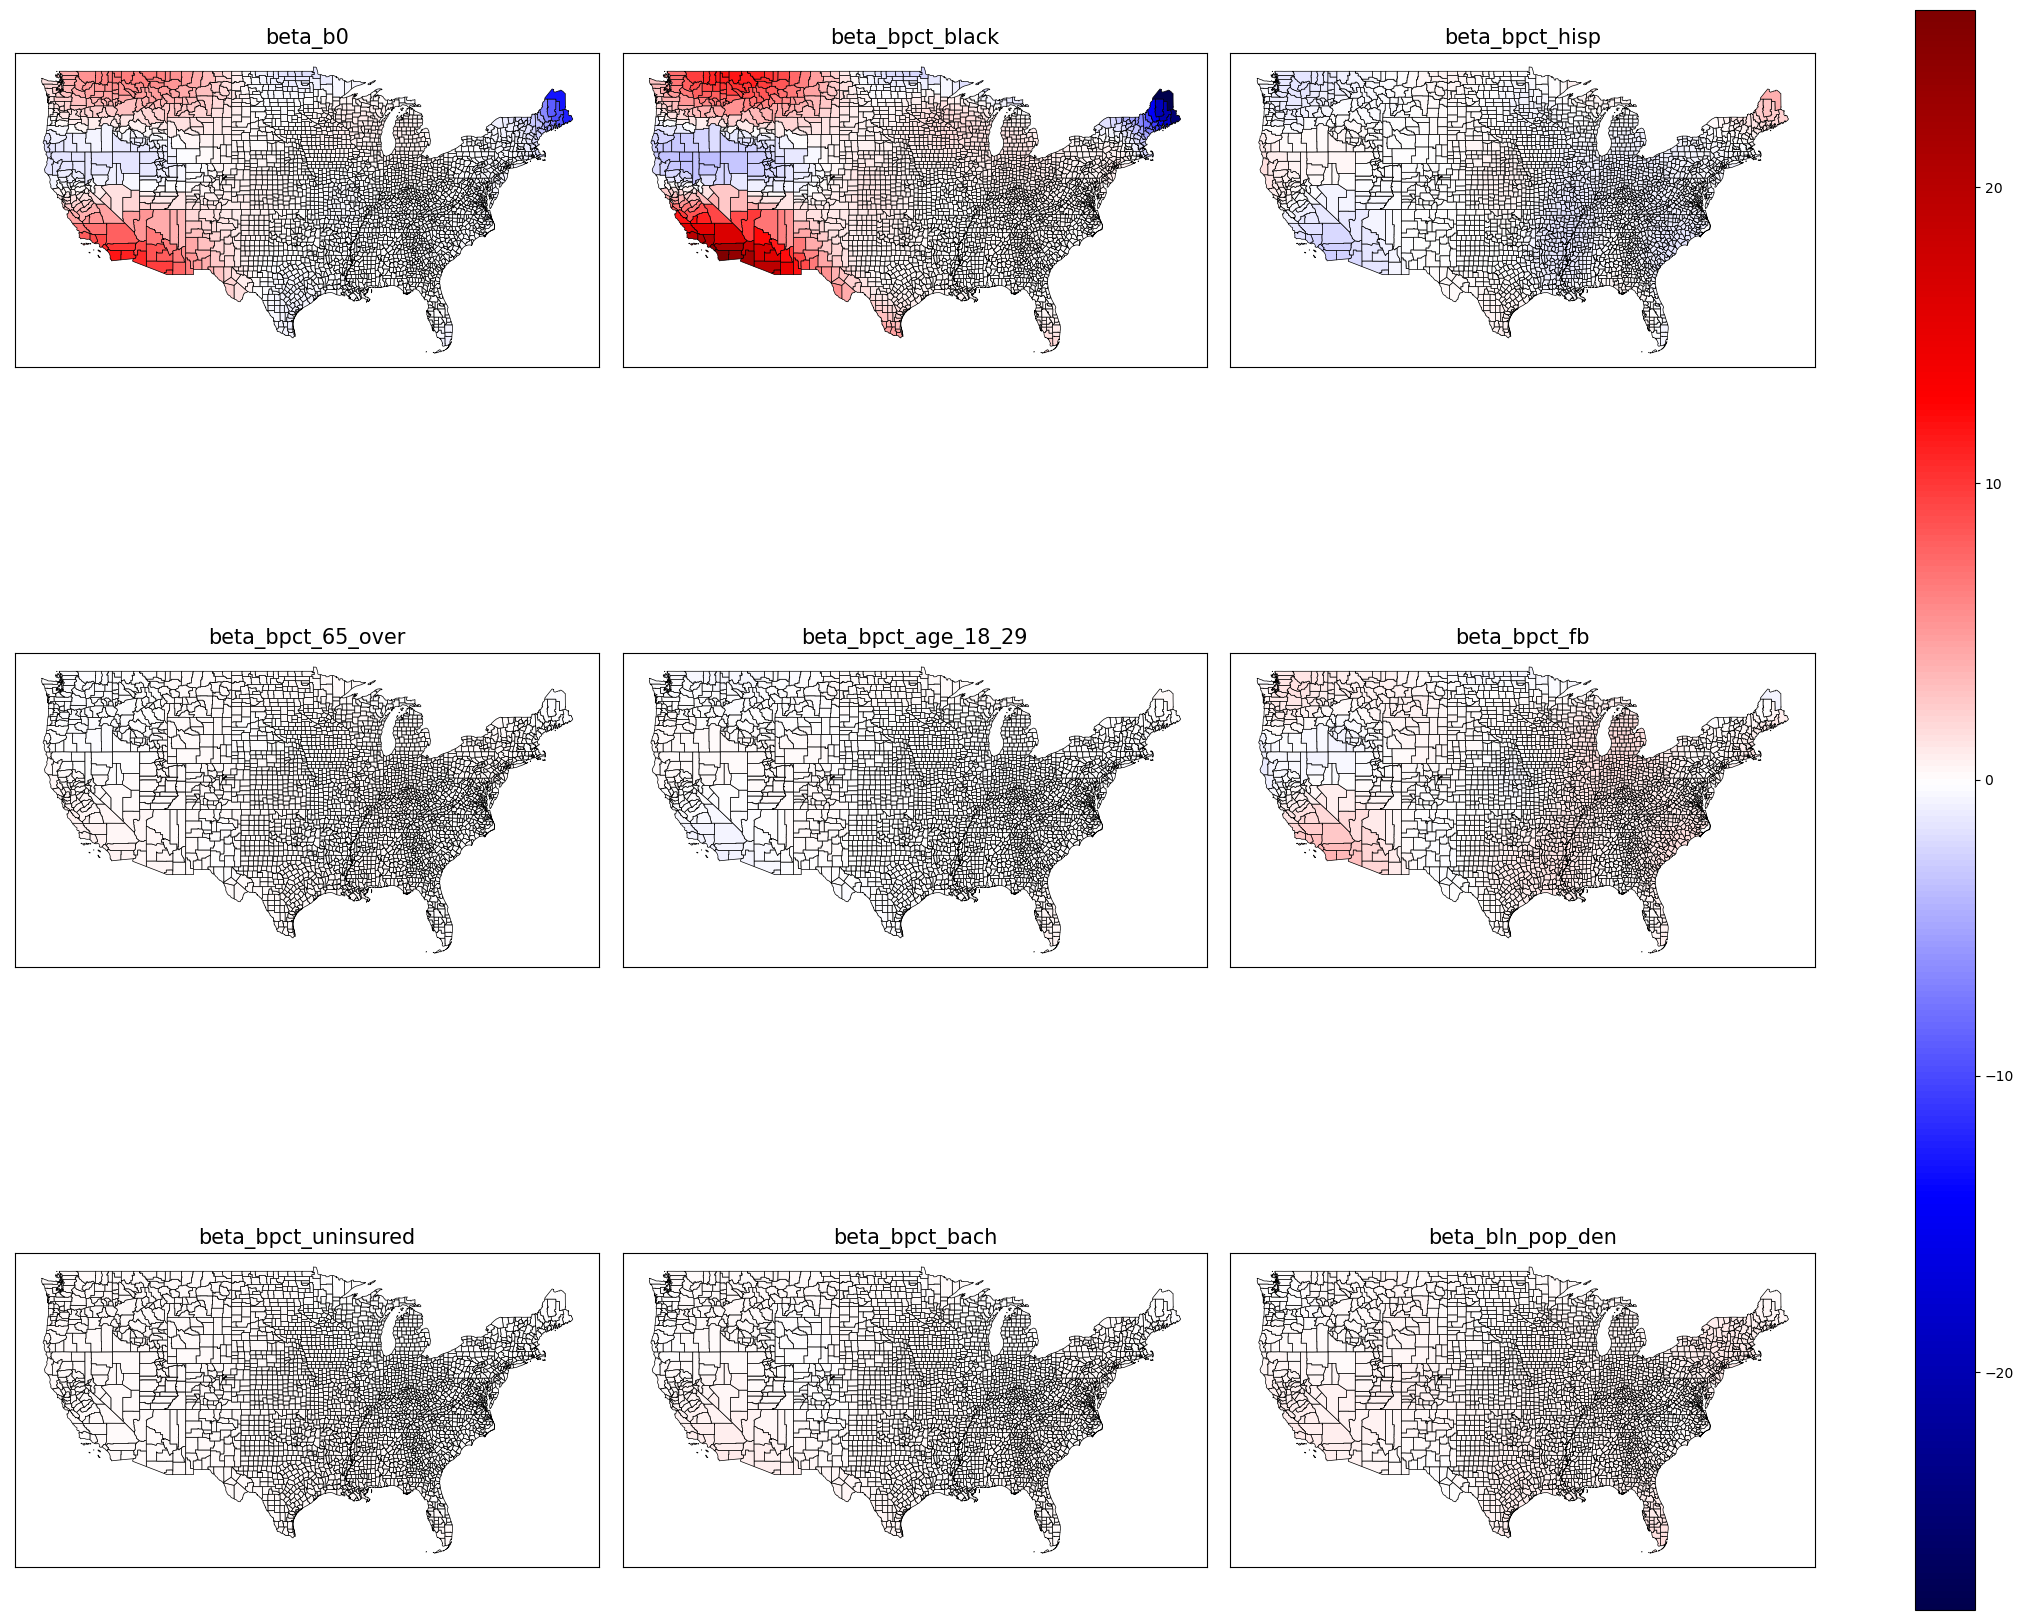

In [19]:
betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]

viz_gw(
        data['geometry'], 
        df3[betas], 
        df3[std_e], 
        alpha=0.05,
        use_tvalues=False,
#         coef_surfaces=['beta_bpct_hisp']
)

#### Similar to utility 1,  the user specifies what surfaces they want to visualize, following best practices we recommend in the paper

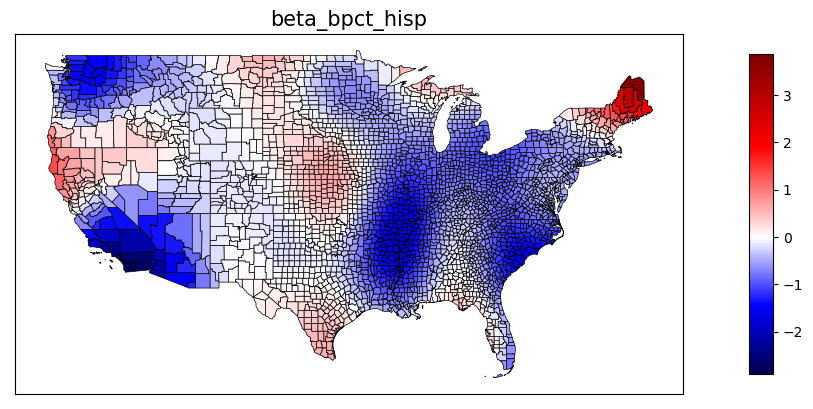

In [20]:
viz_gw(
        data['geometry'], 
        df3[betas], 
        df3[std_e], 
        alpha=0.05,
        use_tvalues=False,
        coef_surfaces=['beta_bpct_hisp']
)

<!-- The dependent variable here is the number of democratic votes and all these others 
are the independent variable. Thanks for watching! -->

<br />

--

## Utility 3

- The svc-viz tool can also be used to visualize the coefficients of two different SVC models to understand the underlying processes and relationships that exist within that geographical contexts and more importantly assess the similarities or differences between one model's specification over the other.

- This method takes as input: the original dataframe, the dataframe of the model estimates and their standard errors, the name of the coefficient that the user wishes to visualize, and the level of statistical significance for the tvalues of both SVC models. By default, it is set to 0.05

- below is an example using a GWR model and a GAM with Gaussian process splines calibrated on the same dataset. 

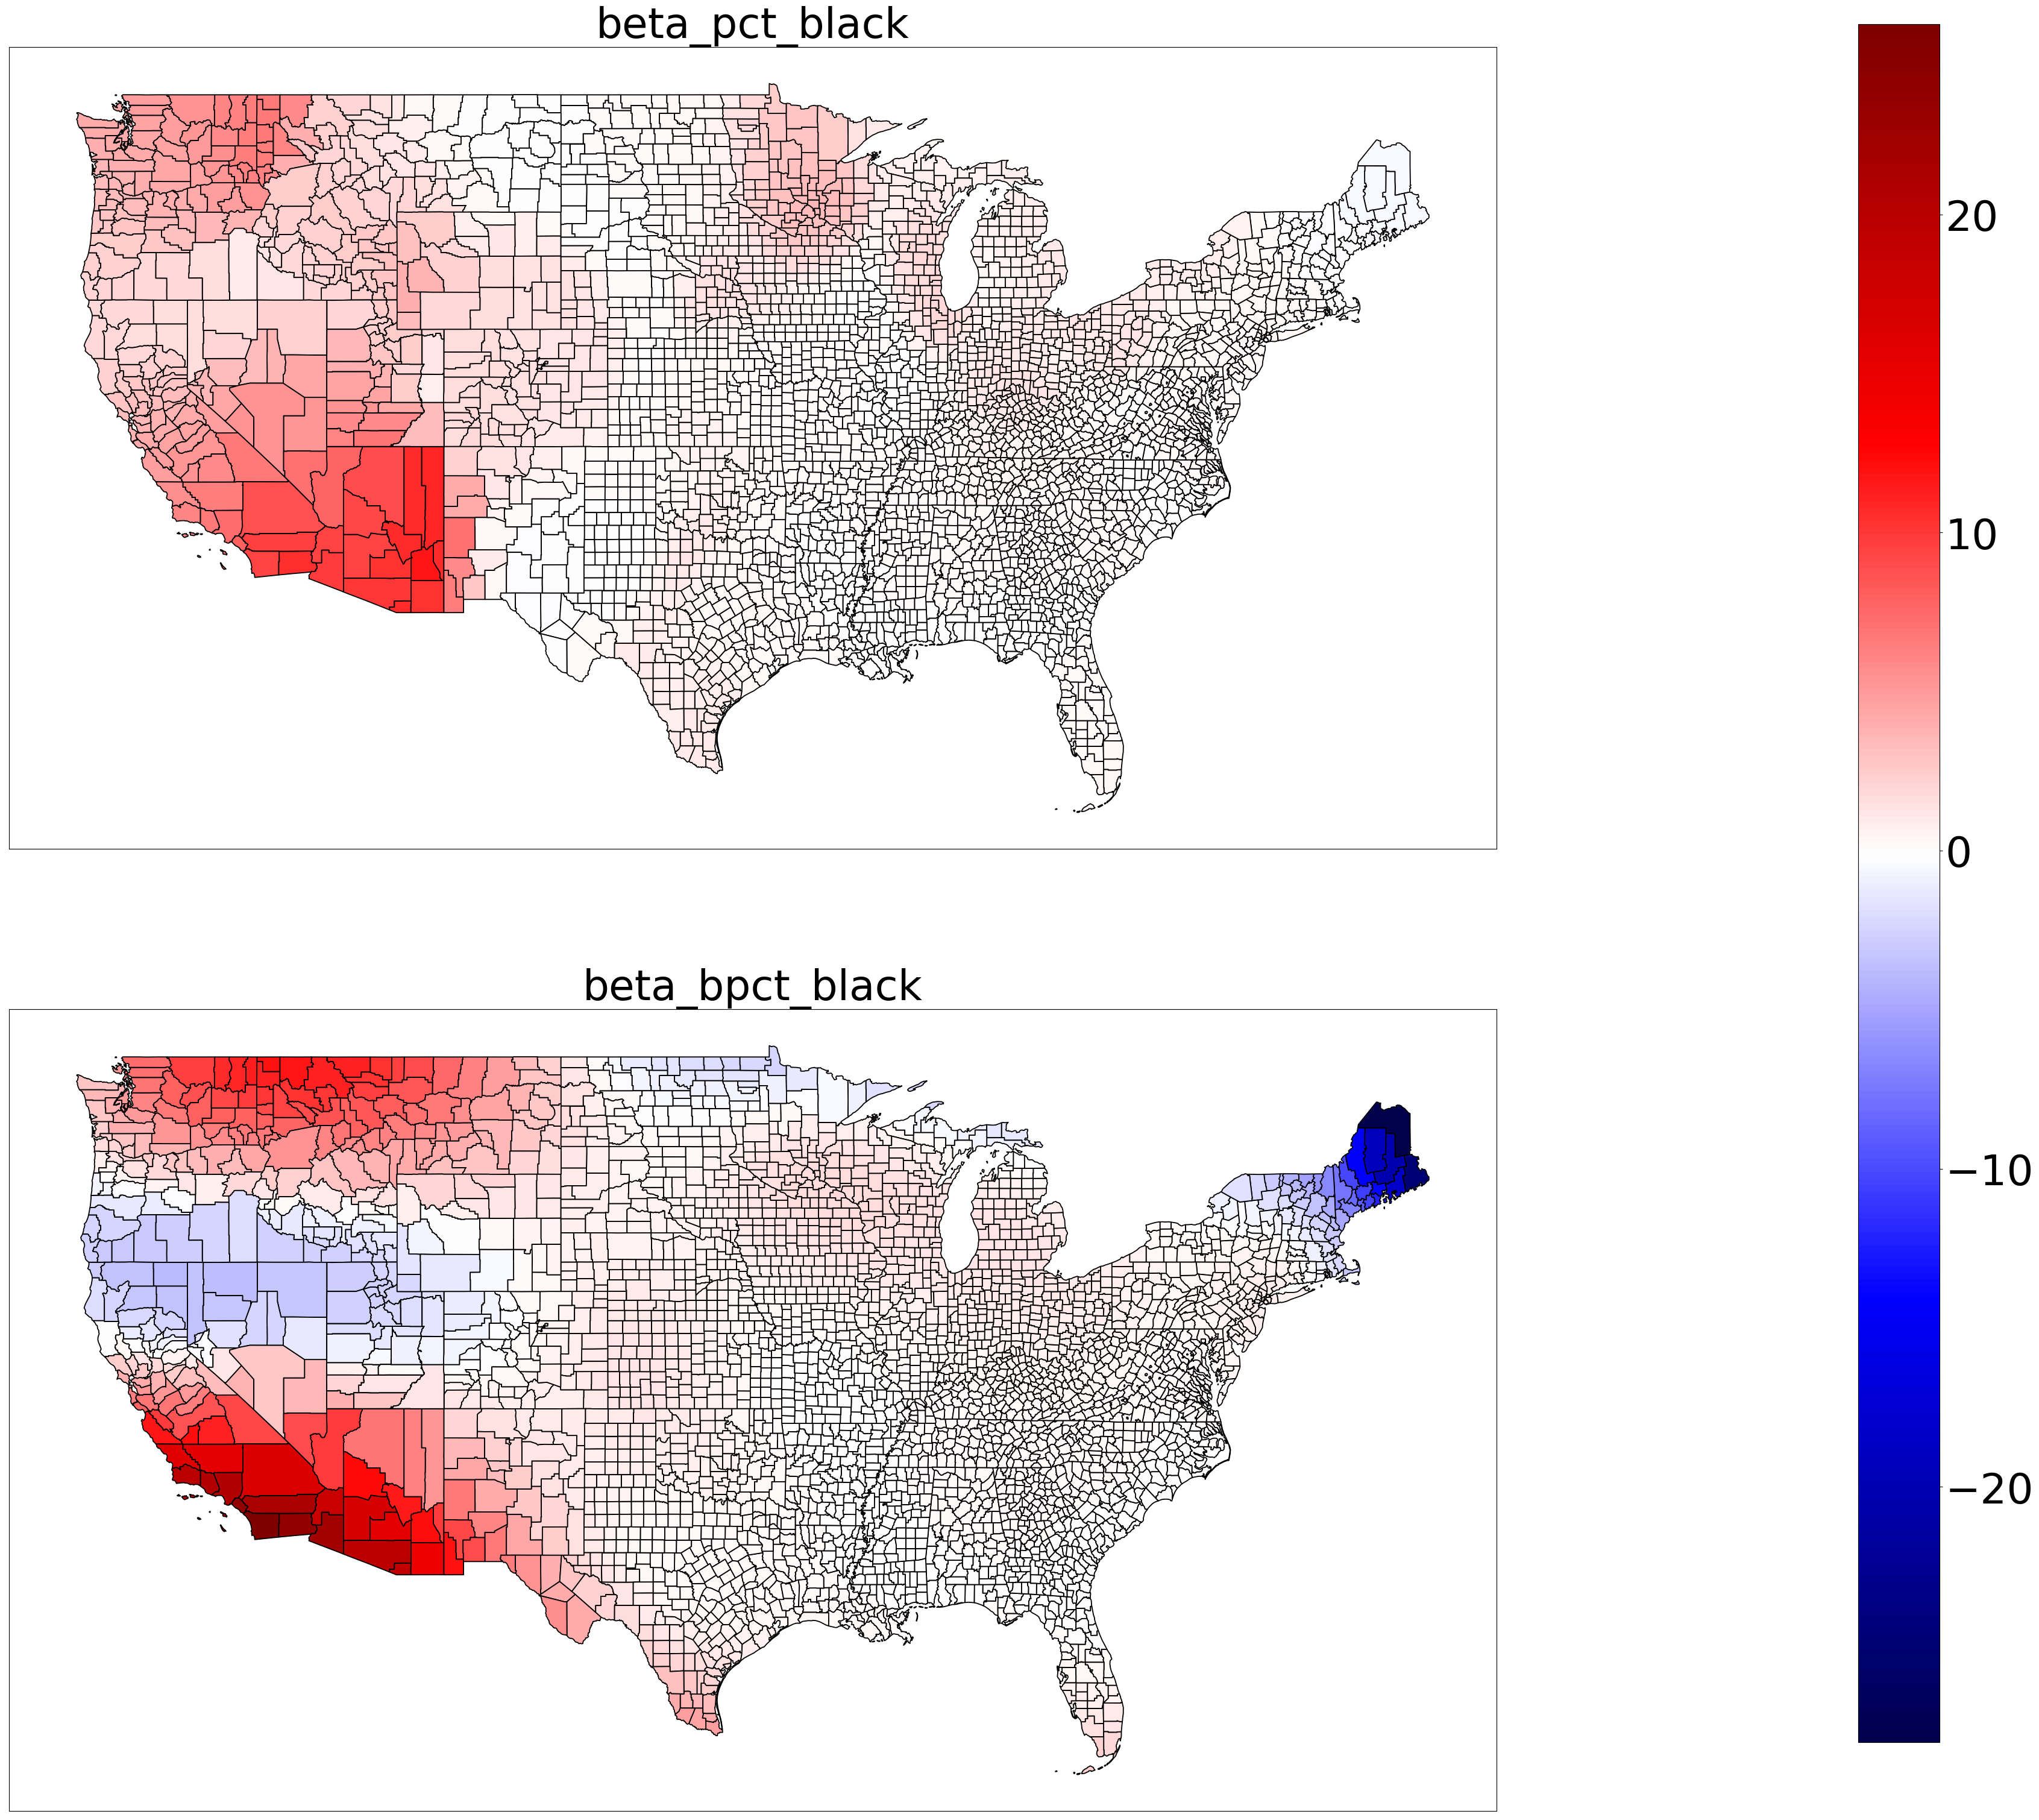

In [21]:
col_names = ['intercept']+col_names

gwr_est = pd.DataFrame(gwr_results.params, columns=col_names)
gwr_std = pd.DataFrame(gwr_results.bse, columns=col_names)

betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]

compare_two_surf(
        data['geometry'], 
        gwr_est, 
        gwr_std, 
        df3[betas],
        df3[std_e], 
        'beta_pct_black', 
        'beta_bpct_black',
        use_tvalues=False
)

<br />

## Utility 4

- The svc-viz tool can generate  a simple plot of confidence intervals to see locations where two different models overlap and locations where they do not overlap - this is to enhance our understanding of if the relationships are replicable or not. <br /> <br /> The user specifies the level of significance, but by default we set it to 95%. <br /> However, as per schenker et al. 2001, overlapping confidence intervals alone are not enough to assess that they are same. More testing is required, e.g hypothesis testing with t-tests, which is part of the best practices we recommend and is incorporated in this tool.

- This method takes as input: the original dataframe, the dataframe of the model estimates and their standard errors, the name of the coefficient that the user wishes to visualize, and the level of statistical significance for the tvalues of both SVC models. By default, it is set to 0.05

- Below is an example code that plots a map showing locations where the confidence intervals of two svc models overlap and where they do not. Here we use the GWR model and the GAM calibrated with Gaussian process splines on the same datasets

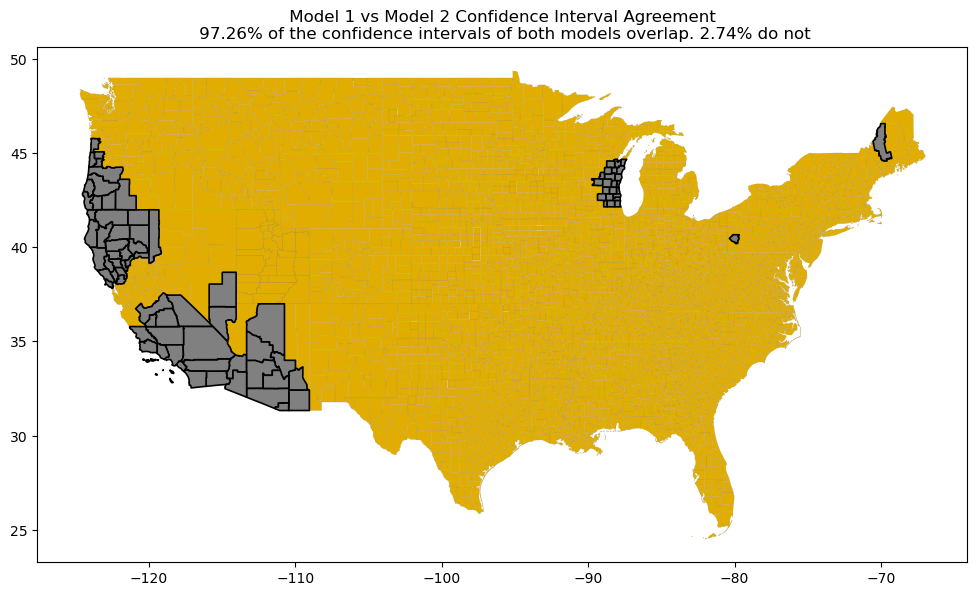

In [22]:
compare_conf(
    data['geometry'],
    gwr_est, 
    gwr_std, 
    df3[betas],
    df3[std_e],
    'pct_hisp',
    'bpct_hisp',
)

### End Notes

<br/>

--